In [1]:
import os
import copy
# from coffea import hist
import hist
from coffea import util
import numpy as np
import itertools
import pandas as pd
from scipy.misc import derivative
import scipy.optimize as sciop
import scipy.special as scisp
from scipy.interpolate import make_interp_spline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
# warnings.filterwarnings("ignore")
import mplhep as hep
from hist.intervals import ratio_uncertainty

In [2]:
btag = 'MediumBTag'
year = '2016'
runB = False

In [3]:
directory = 'CoffeaOutputsForTriggerAnalysis/SingleMu/'+btag+'/'+year+'/'

In [4]:
Data_out = util.load(directory+'TTbarRes_0l_SingleMu'+year+'_Data_TriggerAnalysis.coffea')
if year == '2017' and runB:
    Data_out = util.load(directory+'TTbarRes_0l_SingleMu'+year+'B_Data_TriggerAnalysis.coffea')

In [5]:
print("-------Unweighted SingleMu"+year+"_Data--------")
for i,j in Data_out['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------Unweighted SingleMu2016_Data--------
          all events :    149916849
events with Loose Jet ID :     11445572
events with pT,y Cut :       563175
events with two FatJets :       221148
events with >= oneTTbar :       221148
events with dPhi Cut :       110270
events with Good Subjets :       107255
events with jets cond1 :        47161
events with jets cond2 :        47161
events with jets cond3 :        47488
events with jets cond4 :        47785
events with jets Denom cond :        49979
jets cond1 with ak4cut :       193981
jets cond2 with ak4cut :       193981
jets cond3 with ak4cut :       194989
jets cond4 with ak4cut :       196033
jets Denom with ak4cut :       202085
               NoCut :        49979
                >=1t :        18098


In [6]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [7]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [8]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
# ttagcats = ["NoCut", ">=1t"]
ttagcats = [0, 1]

In [9]:
def plotratio(numerator, denominator, ax=None, histtype='errorbar', marker='.', markersize=5., color='k', alpha=0.1):
    NumeratorAxes = numerator.axes
    DenominatorAxes = denominator.axes
    
    # integer number of bins in this axis #
    NumeratorAxis1_BinNumber = NumeratorAxes[0].size - 3 # Subtract 3 to remove overflow
    
    DenominatorAxis1_BinNumber = DenominatorAxes[0].size - 3 
    
    if(NumeratorAxis1_BinNumber != DenominatorAxis1_BinNumber):
        raise Exception('Numerator and Denominator axes are different sizes; Cannot perform division.')
    # else:
    #     Numerator = numerator.to_hist()
    #     Denominator = denominator.to_hist()
        
    ratio = numerator / denominator.values()
    
    if histtype == 'errorbar':
        return hep.histplot(ratio, ax=ax, histtype=histtype, marker=marker, markersize=markersize, color=color)
    elif histtype == 'fill':
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color, alpha=alpha, lw=5.)
    else:
        return hep.histplot(ratio, ax=ax, histtype=histtype, color=color)

In [10]:
def plotratio2d(numerator, denominator, ax=None, cmap='Blues', cbar=True):
    NumeratorAxes = numerator.axes
    DenominatorAxes = denominator.axes
    
    # integer number of bins in this axis #
    NumeratorAxis1_BinNumber = NumeratorAxes[0].size - 3 # Subtract 3 to remove overflow
    NumeratorAxis2_BinNumber = NumeratorAxes[1].size - 3
    
    DenominatorAxis1_BinNumber = DenominatorAxes[0].size - 3 
    DenominatorAxis2_BinNumber = DenominatorAxes[1].size - 3 
    
    if(NumeratorAxis1_BinNumber != DenominatorAxis1_BinNumber 
       or NumeratorAxis2_BinNumber != DenominatorAxis2_BinNumber):
        raise Exception('Numerator and Denominator axes are different sizes; Cannot perform division.')
    # else:
    #     Numerator = numerator.to_hist()
    #     Denominator = denominator.to_hist()
        
    ratio = numerator / denominator.values()

    return hep.hist2dplot(ratio, ax=ax, cmap=cmap, norm=colors.Normalize(0.,1.), cbar=cbar)

In [11]:
maindirectory = os.getcwd() 

# Plots

In [12]:
SaveDirectory = maindirectory + '/TriggerAnalysisPlots/'+btag+'/'+year+'/' # Directory where trigger analysis plots will be saved
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

# Individual Triggers Plotted as Functions of AK4 Jet $H_T$, AK8 $M_{SD}$ and Invariant $t\bar{t}$ Mass

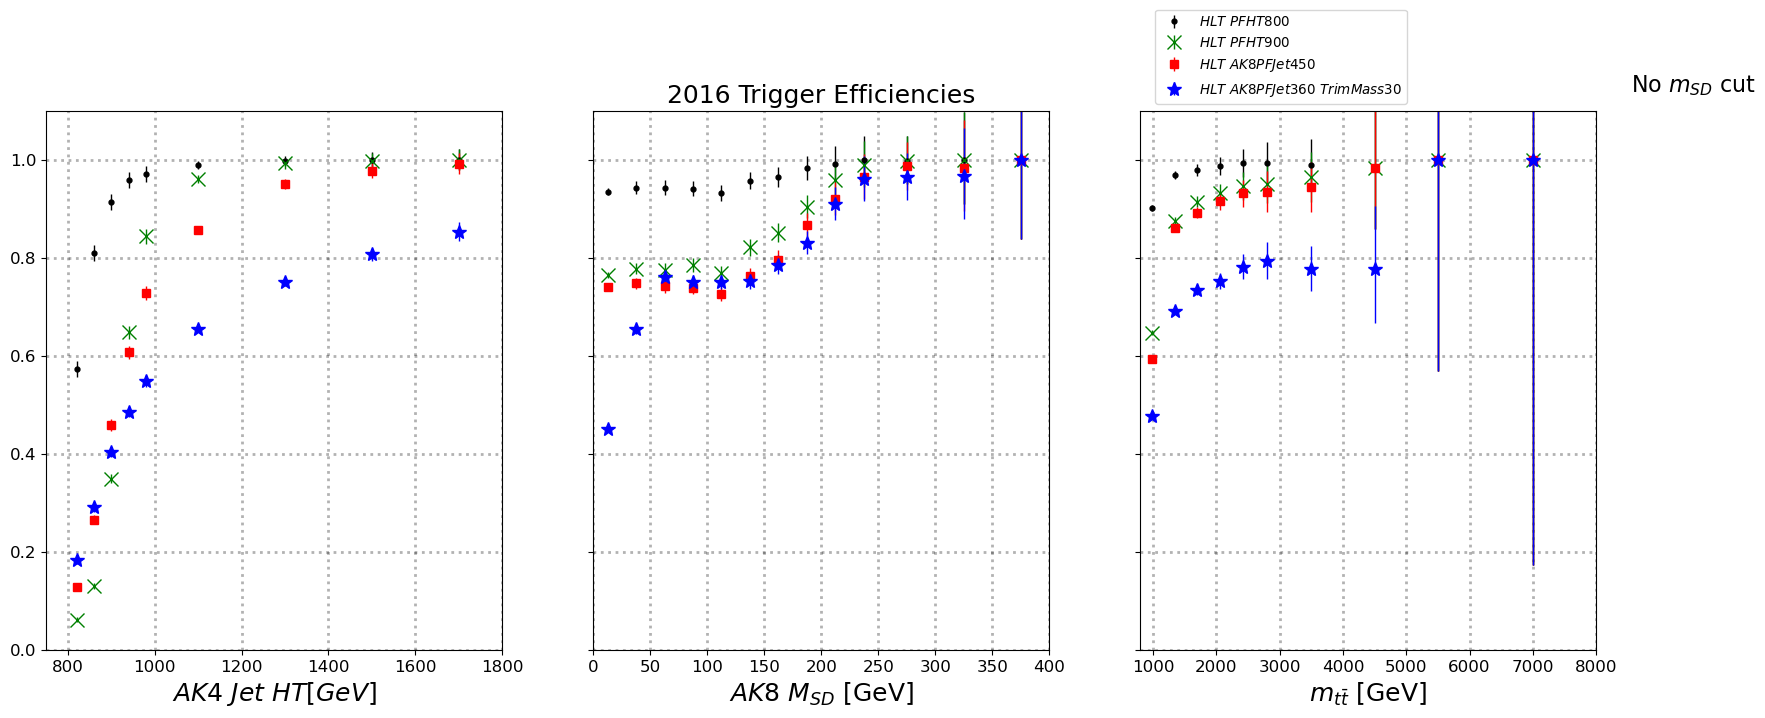

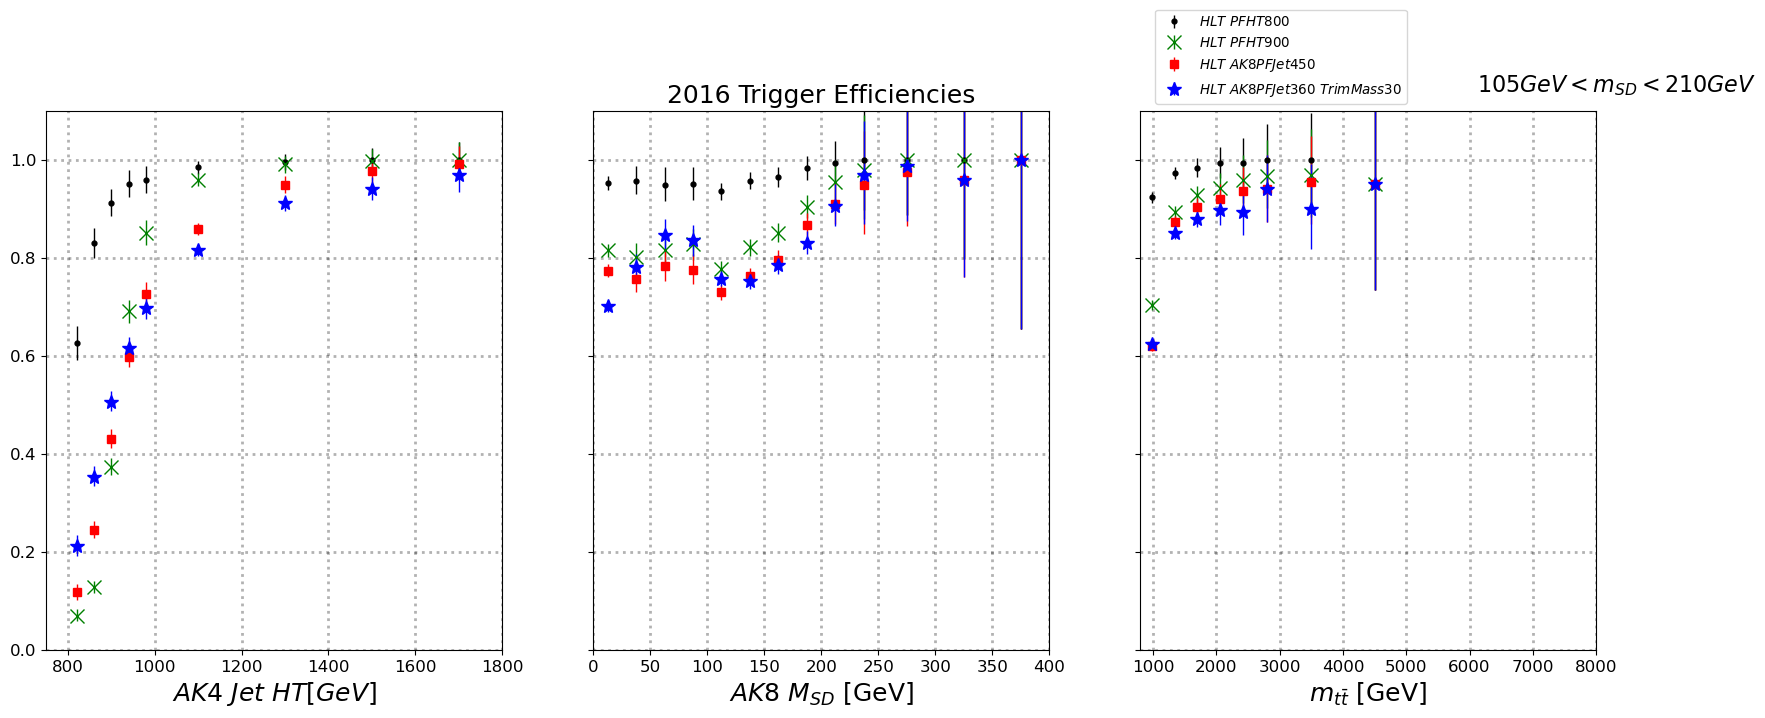

In [23]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

for cat in ttagcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    
    fig, (ax, bx, cx) = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(20,7),
        sharey=True
        # sharex=True
    )
    
    bx.set_title(year + ' Trigger Efficiencies')
    fig.subplots_adjust(hspace=.07)
    
    Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum, sum]
    Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, :, sum]
    Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, sum, :]
    
    if year == '2016':
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator4_ht = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator4_sd = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator4_tt = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '*', 10., 'b')
        EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, bx, 'errorbar', '*', 10., 'b')
        EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, cx, 'errorbar', '*', 10., 'b')
        
        leg = cx.legend(labels=[r'$HLT\ PFHT800$',r'$HLT\ PFHT900$',r'$HLT\ AK8PFJet450$',r'$HLT\ AK8PFJet360\ TrimMass30$'], 
                        bbox_to_anchor=(0.60, 1.20), loc='upper right', fontsize='x-small')
    
    elif year == '2017' and runB:
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator4_ht = Data_out['trigger4_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator4_sd = Data_out['trigger4_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator4_tt = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '*', 10., 'b')
        EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, bx, 'errorbar', '*', 10., 'b')
        EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, cx, 'errorbar', '*', 10., 'b')
        
        leg = cx.legend(labels=[r'$hist_1$',r'$hist_2$',r'$hist_3$',r'$hist_4$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        
    elif year == '2017' and not runB:
        
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        leg = cx.legend(labels=[r'$hist_1$',r'$hist_2$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        
    else: # year 2018
        
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        leg = cx.legend(labels=[r'$$',r'$hist_2$',r'$hist_3$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        # print(Numerator4 / Denominator.values())
 
    # ax.set_title(year + ' Trigger Efficiencies')
    ax.set_xlim(750, 1800)
    bx.set_xlim(0, 400)
    cx.set_xlim(800, 8000)
    
    ax.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    bx.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    cx.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    
    ax.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    bx.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    cx.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    
    ax.set_ylim(bottom=0., top=1.1)
    bx.set_ylim(bottom=0., top=1.1)
    cx.set_ylim(bottom=0., top=1.1)
    
    Cat_legend_entry = None
    if cat == 0:
        Cat_legend_entry = "No $m_{SD}$ cut"
        fnc = '_noSD'
    else:
        Cat_legend_entry = "$105GeV < m_{SD} < 210GeV$"
        fnc = '_SD'
    leg2 = plt.text(1.35, 1.07, Cat_legend_entry,
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=cx.transAxes
               )
    # filename = 'TriggerEffs' + fnc +'.png'
    # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    # print(SaveDirectory+filename)

# Combination of Triggers (Conditions) Plotted as Functions of AK4 Jet $H_T$, AK8 $M_{SD}$ and Invariant $t\bar{t}$ Mass

                    ┌────────────────────────────────────────────────────────┐
[-inf,  200) 0      │                                                        │
[ 200,  800) 0.4536 │                                                        │
[ 800,  840) 0.613  │                                                        │
[ 840,  880) 0.8426 │                                                        │
[ 880,  920) 0.9433 │                                                        │
[ 920,  960) 0.9815 │                                                        │
[ 960, 1000) 0.9897 │                                                        │
[1000, 1200) 0.998  │                                                        │
[1200, 1400) 1      │                                                        │
[1400, 1600) 0.9998 │                                                        │
[1600, 1800) 1      │                                                        │
[1800, 2000) 1      │                               

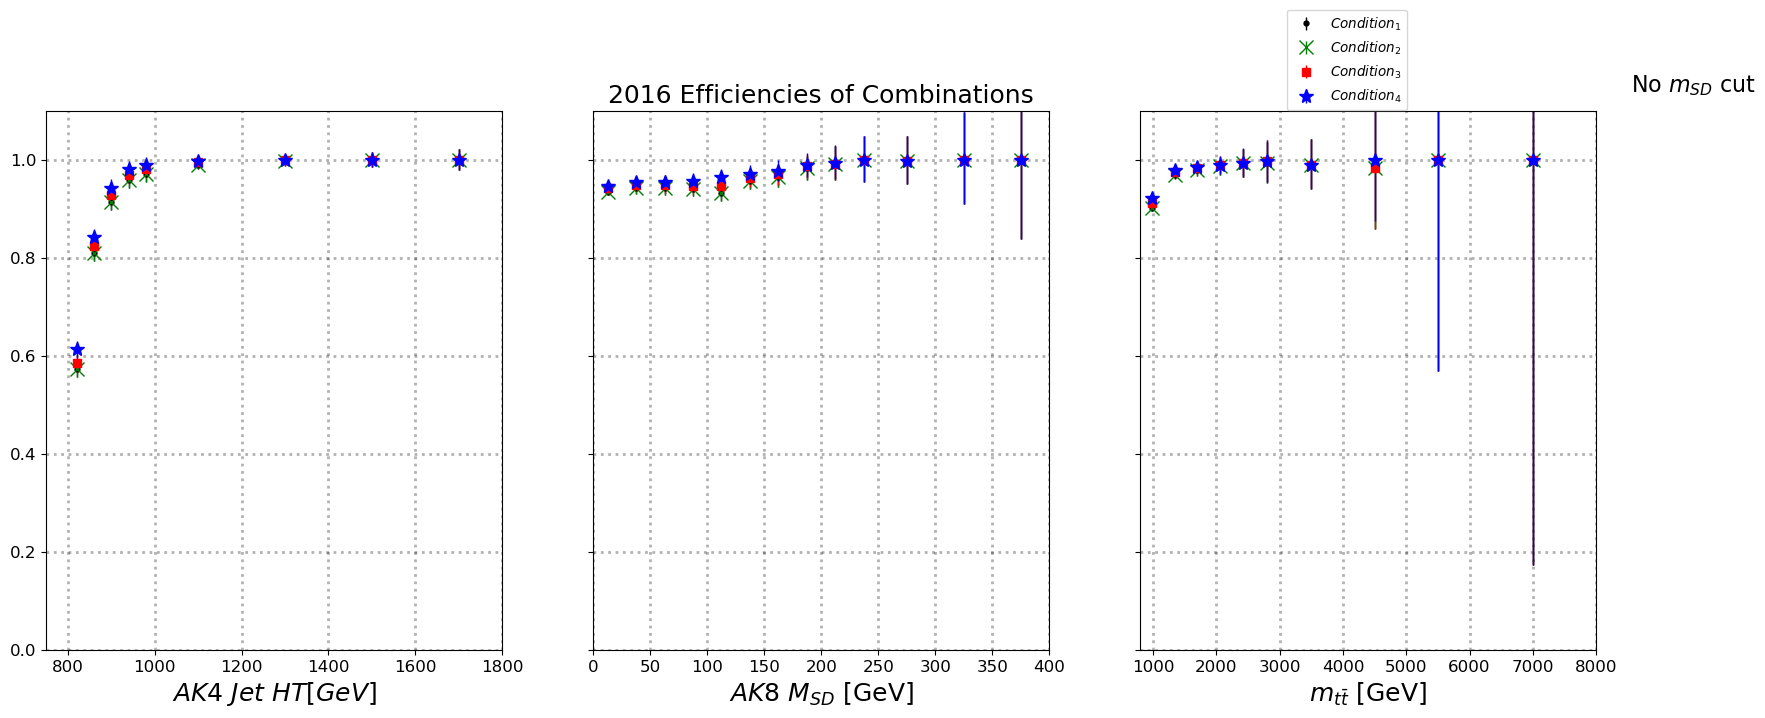

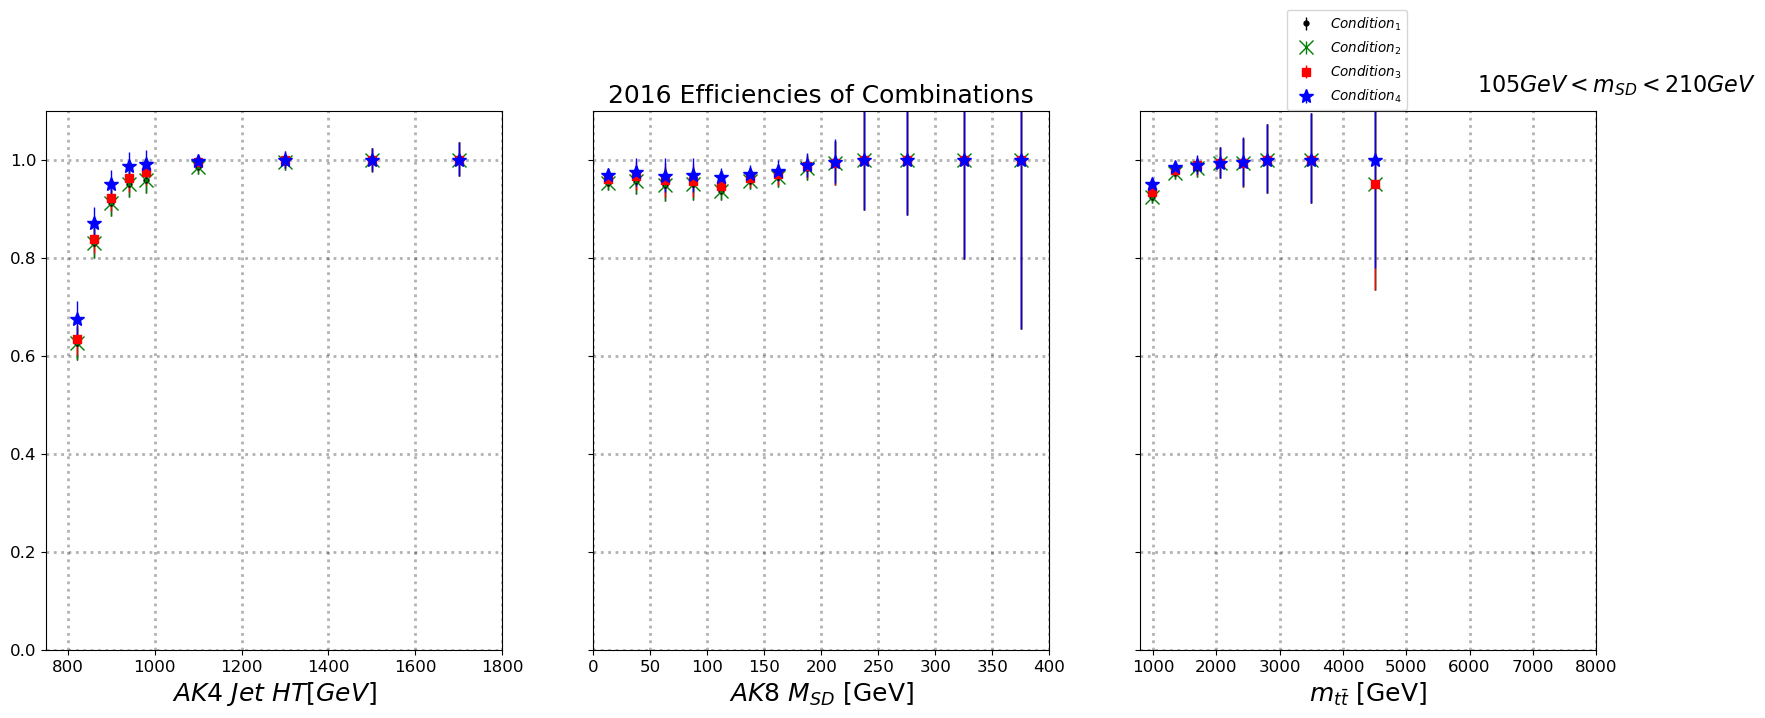

In [26]:
# Numerator1 = Data_num['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum]
# Denominator = Data_num['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum]

for cat in ttagcats:
    #---- Histogram Window Config. ----# 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    
    fig, (ax, bx, cx) = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(20,7),
        sharey=True
        # sharex=True
    )
    
    bx.set_title(year + ' Efficiencies of Combinations')
    fig.subplots_adjust(hspace=.07)
    
    Denominator_ht = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, :, sum, sum]
    Denominator_sd = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, :, sum]
    Denominator_tt = Data_out['condition_denominator']['SingleMu'+year+'_Data', cat, sum, sum, :]
    
    if year == '2016':
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        Numerator4_ht = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        Numerator4_sd = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['condition1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['condition2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['condition3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator4_tt = Data_out['condition4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '*', 10., 'b')
        EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, bx, 'errorbar', '*', 10., 'b')
        EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, cx, 'errorbar', '*', 10., 'b')
        
        leg = cx.legend(labels=[r'$Condition_1$',r'$Condition_2$', r'$Condition_3$', r'$Condition_4$'], 
                        bbox_to_anchor=(0.60, 1.20), loc='upper right', fontsize='x-small')
        
        print(Numerator4_ht / Denominator_ht.values())
    
    elif year == '2017' and runB:
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator4_ht = Data_out['trigger4_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator4_sd = Data_out['trigger4_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator4_tt = Data_out['trigger4_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]

        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        EffPlot4_ht = plotratio(Numerator4_ht, Denominator_ht, ax, 'errorbar', '*', 10., 'b')
        EffPlot4_sd = plotratio(Numerator4_sd, Denominator_sd, bx, 'errorbar', '*', 10., 'b')
        EffPlot4_tt = plotratio(Numerator4_tt, Denominator_tt, cx, 'errorbar', '*', 10., 'b')
        
        leg = cx.legend(labels=[r'$hist_1$',r'$hist_2$',r'$hist_3$',r'$hist_4$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        
        print(Numerator4 / Denominator.values())
        
    elif year == '2017' and not runB:
        
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        leg = cx.legend(labels=[r'$hist_1$',r'$hist_2$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        
        print(Numerator2 / Denominator.values())
        
    else: # year 2018
        
        # ------------------------------------------------------------------------------------- #
        Numerator1_ht = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator2_ht = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        Numerator3_ht = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, :, sum, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_sd = Data_out['trigger1_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator2_sd = Data_out['trigger2_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        Numerator3_sd = Data_out['trigger3_numerator']['SingleMu'+year+'B_Data', cat, sum, :, sum]
        # ------------------------------------------------------------------------------------- #
        Numerator1_tt = Data_out['trigger1_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator2_tt = Data_out['trigger2_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        Numerator3_tt = Data_out['trigger3_numerator']['SingleMu'+year+'_Data', cat, sum, sum, :]
        
        EffPlot1_ht = plotratio(Numerator1_ht, Denominator_ht, ax, 'errorbar', '.', 7., 'k')
        EffPlot1_sd = plotratio(Numerator1_sd, Denominator_sd, bx, 'errorbar', '.', 7., 'k')
        EffPlot1_tt = plotratio(Numerator1_tt, Denominator_tt, cx, 'errorbar', '.', 7., 'k')
        
        EffPlot2_ht = plotratio(Numerator2_ht, Denominator_ht, ax, 'errorbar', 'x', 10., 'g')
        EffPlot2_sd = plotratio(Numerator2_sd, Denominator_sd, bx, 'errorbar', 'x', 10., 'g')
        EffPlot2_tt = plotratio(Numerator2_tt, Denominator_tt, cx, 'errorbar', 'x', 10., 'g')
        
        EffPlot3_ht = plotratio(Numerator3_ht, Denominator_ht, ax, 'errorbar', 's', 6., 'r')
        EffPlot3_sd = plotratio(Numerator3_sd, Denominator_sd, bx, 'errorbar', 's', 6., 'r')
        EffPlot3_tt = plotratio(Numerator3_tt, Denominator_tt, cx, 'errorbar', 's', 6., 'r')
        
        leg = cx.legend(labels=[r'$$',r'$hist_2$',r'$hist_3$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
        
        print(Numerator3 / Denominator.values())
        
 
    # ax.set_title(year + ' Trigger Efficiencies')
    ax.set_xlim(750, 1800)
    bx.set_xlim(0, 400)
    cx.set_xlim(800, 8000)
    
    ax.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    bx.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    cx.grid(axis="x", color="k", alpha=.3, linewidth=2, linestyle=":")
    
    ax.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    bx.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    cx.grid(axis="y", color="k", alpha=.3, linewidth=2, linestyle=":")
    
    ax.set_ylim(bottom=0., top=1.1)
    bx.set_ylim(bottom=0., top=1.1)
    cx.set_ylim(bottom=0., top=1.1)
    
    Cat_legend_entry = None
    if cat == 0:
        Cat_legend_entry = "No $m_{SD}$ cut"
        fnc = '_noSD'
    else:
        Cat_legend_entry = "$105GeV < m_{SD} < 210GeV$"
        fnc = '_SD'
    leg2 = plt.text(1.35, 1.07, Cat_legend_entry,
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=cx.transAxes
               )
    # filename = 'TriggerEffs' + fnc +'.png'
    # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
    # print(SaveDirectory+filename)

# Fit the Plot and Find a Good HT Cut

In [15]:
# def ErrFunctionFit(x, A, B, K, L): # x is numpy array; A and K are fit parameters (constants)
#     return A*scisp.erf(K*x - L) + B

# # z = np.array([1, 2, 3])
# # ErrFunctionFit(z, 3, 1)

In [16]:
# NumVals = Data_num['condition4_numerator'].integrate('anacat', "NoCut").integrate('Jet_sdMass').values()[('SingleMu'+year+'_Data',)]
# DenomVals = Data_num['condition_denominator'].integrate('anacat', "NoCut").integrate('Jet_sdMass').values()[('SingleMu'+year+'_Data',)]

# #Original JetHT Bins [200, 800, 840, 880, 920, 960, 1000, 1200, 1400, 1600, 1800, 2000]
# JetHTVals = np.array([500, 820, 860, 900, 940, 980, 1100, 1300, 1500, 1700, 1900]) # x-data (for fit parameters)
# TriggerEffVals = NumVals/DenomVals # y-data

# Numerator = Data_num['condition4_numerator'].integrate('anacat', "NoCut").integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
# Denominator = Data_num['condition_denominator'].integrate('anacat', "NoCut").integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
# EffPlot = hist.plotratio(num = Numerator, denom = Denominator, clear=False,
#                    error_opts={'marker': '*', 'markersize': 7., 'color': 'b', 'elinewidth': 1},
#                    unc = 'num')

# pfit, pcov = sciop.curve_fit(ErrFunctionFit, xdata=JetHTVals[0:], ydata=TriggerEffVals[0:], 
#                              p0=[0.35, 0.5, 1., 940.], bounds=([0.01, 0.01, 0.01, 500.], [1., 1., 200., 1300.]))
# print('Fit Parameters (A, B, K, L) = ', pfit)
# plt.plot(JetHTVals, ErrFunctionFit(JetHTVals, *pfit), color='red', linewidth=2.5, label=r'Erf Fit')

# Spline = make_interp_spline(JetHTVals, ErrFunctionFit(JetHTVals, *pfit)) # To Smooth Out the Fitting Function

# JetHTVals_smooth = np.linspace(500, 1900, 50) # x-data (a lot of points for plotting smooth function)
# TriggerEffVals_smooth = Spline(JetHTVals_smooth)

# plt.plot(JetHTVals_smooth, TriggerEffVals_smooth, color='blue', linewidth=2.5, label='SPline Erf Fit')
# plt.axvline(1030., 0, 1, color='black', label=r'Turn on at $\approx1030\ GeV$ for 2016')
# plt.axvline(1370., 0, 1, label=r'Turn on at $\approx1360\ GeV$ for 2017 & 2018')
# plt.ylim(bottom=0.6, top=1.1)
# plt.legend()

# filename = 'TriggerEff_HTcut.png'
# # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
# print(SaveDirectory+filename)
# plt.show()

## Plots that are Zoomed in for Detail After "Turn On"

In [17]:
# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=1,
#         figsize=(7,7),
#     )
# #     fig.subplots_adjust(hspace=.07)
#     ax.set_title('Trigger Efficiency')
    
#     Numerator1 = Data_num['condition1_numerator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator2 = Data_num['condition2_numerator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator3 = Data_num['condition3_numerator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator4 = Data_num['condition4_numerator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator5 = Data_num['condition5_numerator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
#     Denominator = Data_num['condition_denominator'].integrate('anacat', cat).integrate('Jet_sdMass').integrate('dataset', 'SingleMu'+year+'_Data')
    
#     # print(Denominator.values())
    
#     # TestPlot = hist.plot1d(Denominator, ax=ax, clear=False, error_opts={'marker': '.', 'markersize': 7., 'color': 'k', 'elinewidth': 1})
    
#     EffPlot1 = hist.plotratio(num = Numerator1, denom = Denominator, ax = ax, clear=False,
#                    error_opts={'marker': '.', 'markersize': 7., 'color': 'k', 'elinewidth': 1},
#                    unc = 'num')
#     EffPlot2 = hist.plotratio(num = Numerator2, denom = Denominator, ax = ax, clear=False,
#                    error_opts={'marker': 'x', 'markersize': 10., 'color': 'g', 'elinewidth': 1},
#                    unc = 'num')
#     EffPlot3 = hist.plotratio(num = Numerator3, denom = Denominator, ax = ax, clear=False,
#                    error_opts={'marker': 's', 'markersize': 6., 'color': 'r', 'elinewidth': 1},
#                    unc = 'num')
#     EffPlot4 = hist.plotratio(num = Numerator4, denom = Denominator, ax = ax, clear=False,
#                    error_opts={'marker': '*', 'markersize': 10., 'color': 'b', 'elinewidth': 1},
#                    unc = 'num')
#     # EffPlot5 = hist.plotratio(num = Numerator5, denom = Denominator, ax = ax, clear=False,
#     #                error_opts={'marker': 'd', 'markersize': 7., 'color': 'm', 'elinewidth': 1},
#     #                unc = 'num')
    
#     # ax.set_ylim(bottom=0.90, top=1.01)
#     # ax.set_xlim(250, 2200)
#     # ax.set_ylabel('Efficiency')
#     # leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$',r'$Condition_3$',r'$Condition_4$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
#     # leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$',r'$Condition_3$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
#     # leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$',r'$Condition_3$',r'$Condition_4$',r'$Condition_5$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
    
#     Cat_legend_entry = None
#     if cat == 'NoCut':
#         Cat_legend_entry = "No $m_{SD}$ cut"
#         fnc = '_noSD'
#     else:
#         Cat_legend_entry = "$105GeV < m_{SD} < 210GeV$"
#         fnc = '_SD'
#     leg2 = plt.text(1.35, 1.07, Cat_legend_entry,
#                 fontsize=16,
#                 horizontalalignment='right',
#                 verticalalignment='top',
#                 transform=ax.transAxes
#                )
#     filename = 'TriggerEffs_zoom' + fnc +'.png'
#     # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     print(SaveDirectory+filename)
    

# 2D Trigger Efficiency Plots

In [18]:
# for cat in ttagcats:
#     #---- Histogram Window Config. ----# 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     # fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
#     #     nrows=3,
#     #     ncols=2,
#     #     figsize=(20,10),
#     # )
#     fig = plt.figure()
#     fig.set_figheight(12)
#     fig.set_figwidth(25)
    
#     ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0))
#     ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 1))
#     ax3 = plt.subplot2grid(shape=(3, 3), loc=(0, 2))
#     ax4 = plt.subplot2grid(shape=(3, 3), loc=(1, 0))
#     ax5 = plt.subplot2grid(shape=(3, 3), loc=(1, 2))
    
# #     fig.subplots_adjust(hspace=.07)
#     # plt.set_title('Trigger Efficiency; ' + cat)
    
#     Numerator1 = Data_num['condition1_numerator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator2 = Data_num['condition2_numerator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator3 = Data_num['condition3_numerator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator4 = Data_num['condition4_numerator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
#     Numerator5 = Data_num['condition5_numerator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
#     Denominator = Data_num['condition_denominator'].integrate('anacat', cat).integrate('dataset', 'SingleMu'+year+'_Data')
    
#     # print(Denominator.values())
    
#     # TestPlot = hist.plot1d(Denominator, ax=ax, clear=False, error_opts={'marker': '.', 'markersize': 7., 'color': 'k', 'elinewidth': 1})
    
#     EffPlot1 = plotratio2d(Numerator1, Denominator, ax=ax1, cmap='Greys')
        
#     EffPlot2 = plotratio2d(Numerator2, Denominator, ax=ax2, cmap='Reds')
    
#     EffPlot3 = plotratio2d(Numerator3, Denominator, ax=ax3, cmap='Greens')
    
#     EffPlot4 = plotratio2d(Numerator4, Denominator, ax=ax4, cmap='Blues')
    
# #     EffPlot5 = plotratio2d(Numerator5, Denominator, ax=ax5, cmap='BuPu')
    
#     # ax.set_ylim(bottom=0.0, top=1.1)
#     # ax.set_xlim(220, 2200)
#     # ax.set_ylabel('Efficiency')
#     # leg = ax.legend(labels=[r'$Condition_1$',r'$Condition_2$',r'$Condition_3$',r'$Condition_4$'], bbox_to_anchor=(1.35, 1.), loc='upper right')
    
#     # Cat_legend_entry = None
#     # if cat == '0t':
#     #     Cat_legend_entry = "No $m_{SD}$ cut"
#     #     fnc = '_noSD'
#     # else:
#     #     Cat_legend_entry = "$105GeV < m_{SD} < 210GeV$"
#     #     fnc = '_SD'
#     # leg2 = plt.text(1.35, 1.07, Cat_legend_entry,
#     #             fontsize=16,
#     #             horizontalalignment='right',
#     #             verticalalignment='top',
#     #             transform=ax.transAxes
#                # )
#     filename = 'TriggerEffs_unc' + fnc +'.png'
#     filename_zoom = 'TriggerEffs_unc_zoom' + fnc + '.png'
#     # plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#     # print(SaveDirectory+filename)
    